<a href="https://colab.research.google.com/github/AtheerMalki/Module04_ML/blob/main/Modeling_Earthquake_Damage_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is part of the deliverables for my final project for Coding Dojo's Data Science Immersive Bootcamp.
It is written as a submission to the [Richter's Predictor: Modeling Earthquake Damage](https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/) competition. 

![image](https://drive.google.com/uc?id=13K-jlykKEWyQl7gRTh91PrNrNLLrLahk)

Image by James Wheeler via [Pexels.](https://www.pexels.com/photo/white-concrete-houses-1531660/)

***Project Goal:*** predict the grade of damage inflicted upon buildings in Nepal after the 2015 earthquake.

In this notebook:
  - [Explore Nepal's 2015 earthquake data](#eda)
  - [Visualize some feature relations using seaborn](#viz)
  - [Handle categorical features using OneHotEncoding and OrdinalEncoding](#handle_cat)
  - [Detect and remove outliers using IsolationForest](#outliers)
  - [Predict damage using Gradient Boosting Classifier](#gbi)
  - [Apply feature selection, make another prediction and compare results](#feat_imp)
  - [Perform SMOTE to handle class imbalance, make another prediction and compare results](#SMOTE)
  - [Upload predictions to csv files](#submit)  


[Submit](https://www.drivendata.org/competitions/57/nepal-earthquake/submissions/) predictions to the competition!

In [ ]:
# import packages and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")
from sklearn.preprocessing import OneHotEncoder #?
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import confusion_matrix

import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# import data files from: https://www.drivendata.org/competitions/57/nepal-earthquake/data/
train_values = pd.read_csv('https://raw.githubusercontent.com/AtheerMalki/Module04_ML/main/Project/data/train_values.csv')
train_labels = pd.read_csv('https://raw.githubusercontent.com/AtheerMalki/Module04_ML/main/Project/data/train_labels.csv')

test_values = pd.read_csv('https://raw.githubusercontent.com/AtheerMalki/Module04_ML/main/Project/data/test_values.csv')

<a name="eda"></a>
# EDA


Observe shape and head() of each dataframe

In [ ]:
print('train_values shape:', train_values.shape)
print('train_labels shape:', train_labels.shape)
print('test_values shape:', test_values.shape)

train_values shape: (260601, 39)
train_labels shape: (260601, 2)
test_values shape: (86868, 39)


In [ ]:
train_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [ ]:
test_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


Merge training and testing values

In [ ]:
# 1st: copy [train_labels]'s 'damage_grade' column to [train_values]
train_values['damage_grade'] = train_labels['damage_grade'].values

# 2nd: concatenate train_values and test_values
frames = [train_values, test_values]
df = pd.concat(frames)
df.set_index='building_id'
df.shape

(347469, 40)

In [ ]:
# observe new dataframe
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0


***Features Description*** 

- **geo_level_1_id, geo_level_2_id, geo_level_3_id (type: int):** geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567.  

- **count_floors_pre_eq (type: int):** number of floors in the building before the earthquake.  

- **age (type: int):** age of the building in years.  

- **area_percentage (type: int):** normalized area of the building footprint.  

- **height_percentage (type: int):** normalized height of the building footprint.  

- **land_surface_condition (type: categorical):** surface condition of the land where the building was built. Possible values: n, o, t.  

- **foundation_type (type: categorical):** type of foundation used while building. Possible values: h, i, r, u, w.  

- **roof_type (type: categorical):** type of roof used while building. Possible values: n, q, x.  

- **ground_floor_type (type: categorical):** type of the ground floor. Possible values: f, m, v, x, z.  

- **other_floor_type (type: categorical):** type of constructions used in higher than the ground floors (except of roof). Possible values: j, q, s, x.   

- **position (type: categorical):** position of the building. Possible values: j, o, s, t.  

- **plan_configuration (type: categorical):** building plan configuration. Possible values: a, c, d, f, m, n, o, q, s, u.   

- **has_superstructure_adobe_mud (type: binary):** flag variable that indicates if the superstructure was made of Adobe/Mud.  

- **has_superstructure_mud_mortar_stone (type: binary):** flag variable that indicates if the superstructure was made of Mud Mortar - Stone.  

- **has_superstructure_stone_flag (type: binary):** flag variable that indicates if the superstructure was made of Stone.  

- **has_superstructure_cement_mortar_stone (type: binary):** flag variable that indicates if the superstructure was made of Cement Mortar - Stone.

- **has_superstructure_mud_mortar_brick (type: binary):** flag variable that indicates if the superstructure was made of Mud Mortar - Brick.  

- **has_superstructure_cement_mortar_brick (type: binary):** flag variable that indicates if the superstructure was made of Cement Mortar - Brick.  

- **has_superstructure_timber (type: binary):** flag variable that indicates if the superstructure was made of Timber.  

- **has_superstructure_bamboo (type: binary):** flag variable that indicates if the superstructure was made of Bamboo.  

- **has_superstructure_rc_non_engineered (type: binary):** flag variable that indicates if the superstructure was made of non-engineered reinforced concrete.  

- **has_superstructure_rc_engineered (type: binary):** flag variable that indicates if the superstructure was made of engineered reinforced concrete.  

- **has_superstructure_other (type: binary):** flag variable that indicates if the superstructure was made of any other material.  

- **legal_ownership_status (type: categorical):** legal ownership status of the land where building was built. Possible values: a, r, v, w.  

- **count_families (type: int):** number of families that live in the building.  

- **has_secondary_use (type: binary):** flag variable that indicates if the building was used for any secondary purpose.  

- **has_secondary_use_agriculture (type: binary):** flag variable that indicates if the building was used for agricultural purposes.  

- **has_secondary_use_hotel (type: binary):** flag variable that indicates if the building was used as a hotel.  

- **has_secondary_use_rental (type: binary):** flag variable that indicates if the building was used for rental purposes.  

- **has_secondary_use_institution (type: binary):** flag variable that indicates if the building was used as a location of any institution.  

- **has_secondary_use_school (type: binary):** flag variable that indicates if the building was used as a school.  

- **has_secondary_use_industry (type: binary):** flag variable that indicates if the building was used for industrial purposes.  

- **has_secondary_use_health_post (type: binary):** flag variable that indicates if the building was used as a health post.  

- **has_secondary_use_gov_office (type: binary):** flag variable that indicates if the building was used fas a government office.  

- **has_secondary_use_use_police (type: binary):** flag variable that indicates if the building was used as a police station.  

- **has_secondary_use_other (type: binary):** flag variable that indicates if the building was secondarily used for other purposes.
- **damage_grade (type: int):** represents the level of damage. 1: low damage. 2: medium damage. 3: great damage/destruction.

In [ ]:
# check for missing values
def missing_values_table(df):
    
    mis_val = df.isnull().sum() # total
    
    mis_val_percent = 100 * df.isnull().sum() / len(df) # percentage
    
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) # create a table
    
    mis_val_table_ren_columns = mis_val_table.rename(                  # rename columns
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
  
    # .iloc[:, 1]!= 0: filter on missing values not equal to zero
    mis_val_table_ren_columns = mis_val_table_ren_columns[        # sort by percentage (descending)
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)
    
    print("Your selected dataframe has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    
    return mis_val_table_ren_columns

In [ ]:
missing_values_table(df)

Your selected dataframe has 40 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
damage_grade,86868,25.0


Theses 86868 values are in fact the *to be predected labels* = there are no missing values, nice!

<a name="viz"></a>
## Visualization

In [ ]:
#import pandas_profiling
#pandas_profiling.ProfileReport(df)

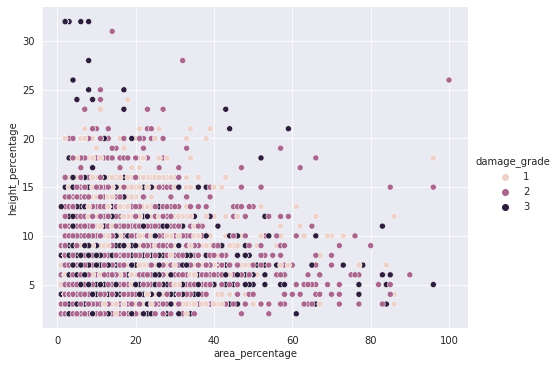

In [ ]:
# plot the relation between a building's area and height with distinction of the damage grade
sns.relplot(
    data=train_values,
    x="area_percentage", y="height_percentage",
    hue="damage_grade", aspect=11.7/9
)

Some observations:  

Majority of point are purple. Purple = damage_grade 2. This might indicate the presence of class inbalance.    

Several buildings with high percentage of height and relatively smaller areas appear to be classified with damage_grade **3** (see top-left corner of plot). It seems logical to assume the higher the building, and the smaller its area, the more damage it will endure.

Majority of data points are in the bottom-left side of the plot, yet there are some values that seem to be distant. This might indicate the presence of outliers. 


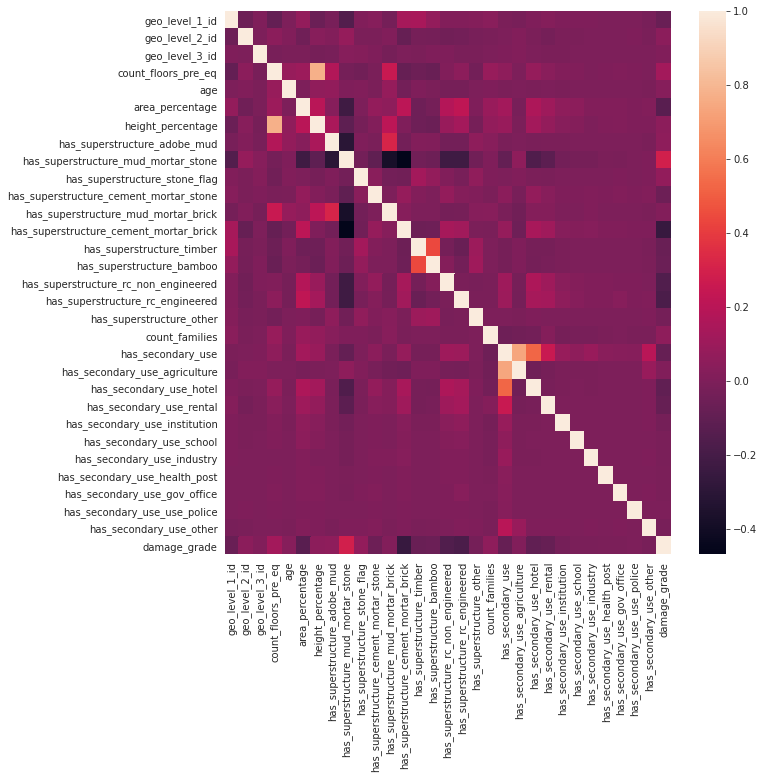

In [ ]:
# plot the heatmap to plot correlation between features
cold_without_flags = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq',
 'age', 'area_percentage', 'height_percentage', 'foundation_type', 'ground_floor_type',
 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status',
 'count_families', 'damage_grade',]

corr = df.drop('building_id', axis=1).corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr, ax=ax)

There seems to be correlation between the features *geo_level_1_id* and *foundation_type*, intersting.  
Also between *area_percentage* and *ground_floor_type*.  

Another nice revelation is seen in the correlations of the feature *has_secondary_use*, as it seems that the most common secondary uses in order are: agriculture, hotel, rental, and institution.  

Some obvious correlations can also be seen such as the one between the building's height and the count of floors.

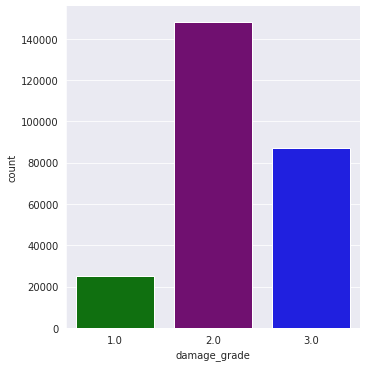

In [ ]:
# A barplot showing how many instances of each class there are
sns.catplot(x='damage_grade', data=df, kind='count', palette=sns.color_palette(['green','purple', 'blue']))

<a name="imbalance"></a>
According to this plot, there seems to be a multiclass imbalance. This means that in this dataset there are more instances where the damage_grade is 2, but less ones where the damage_grade is 1 or 3. This is a problem because the model is not going to be trained well to predict the classes where there is less data. 
One way to fix this is using SMOTE.  

With SMOTE (Synthetic Minority Over-sampling Technique), either oversampling or undersampling can be used on certain classes.  


SMOTE is performed [later](#SMOTE) in the notebook.

<a name="handle_cat"></a>
## Handle categorical features

In [ ]:
# observe columns and their types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347469 entries, 0 to 86867
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             347469 non-null  int64  
 1   geo_level_1_id                          347469 non-null  int64  
 2   geo_level_2_id                          347469 non-null  int64  
 3   geo_level_3_id                          347469 non-null  int64  
 4   count_floors_pre_eq                     347469 non-null  int64  
 5   age                                     347469 non-null  int64  
 6   area_percentage                         347469 non-null  int64  
 7   height_percentage                       347469 non-null  int64  
 8   land_surface_condition                  347469 non-null  object 
 9   foundation_type                         347469 non-null  object 
 10  roof_type                               34746

This dataframe has 31 columns of type **int64**, 8 columns of type **object**, and a single **float46** column(the target).   
.    
.     
.  

Next step: convert all columns to be of numerical type.

In [ ]:
# first, investigate the columns with type 'object'
print(train_values['land_surface_condition'].value_counts(), '\n')
print(train_values['foundation_type'].value_counts(), '\n')
print(train_values['roof_type'].value_counts(), '\n')
print(train_values['ground_floor_type'].value_counts(), '\n')

print(train_values['other_floor_type'].value_counts(), '\n')
print(train_values['position'].value_counts(), '\n')
print(train_values['plan_configuration'].value_counts(), '\n')
print(train_values['legal_ownership_status'].value_counts(), '\n')

print(train_values['damage_grade'].value_counts(), '\n')

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64 

r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64 

n    182842
q     61576
x     16183
Name: roof_type, dtype: int64 

f    209619
x     24877
v     24593
z      1004
m       508
Name: ground_floor_type, dtype: int64 

q    165282
x     43448
j     39843
s     12028
Name: other_floor_type, dtype: int64 

s    202090
t     42896
j     13282
o      2333
Name: position, dtype: int64 

d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64 

v    250939
a      5512
w      2677
r      1473
Name: legal_ownership_status, dtype: int64 

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64 



Deal with each column depending on the number of classes it has

In [ ]:
# use OrdinalEncoder to deal with object columns with 4 or more classes
four_more = ['foundation_type', 'ground_floor_type', 'plan_configuration',
             'other_floor_type', 'position', 'legal_ownership_status']
enc = OrdinalEncoder()

df[four_more] = enc.fit_transform(df[four_more])

In [ ]:
# use one hot encoding to deal with object columns with 3 or less classes
three_less = ['land_surface_condition', 'roof_type']
df = pd.get_dummies(df, columns=three_less)

In [ ]:
# while at it, convert uint8 columns to int8 (helpfeul for a later operation: IsolationForest)
uint8_cols = ['land_surface_condition_n', 'land_surface_condition_o', 'land_surface_condition_t',
              'roof_type_n', 'roof_type_q', 'roof_type_x']
df[uint8_cols] = np.int8(df[uint8_cols])

In [ ]:
# check everything is good and all columns are numerical
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347469 entries, 0 to 86867
Data columns (total 44 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             347469 non-null  int64  
 1   geo_level_1_id                          347469 non-null  int64  
 2   geo_level_2_id                          347469 non-null  int64  
 3   geo_level_3_id                          347469 non-null  int64  
 4   count_floors_pre_eq                     347469 non-null  int64  
 5   age                                     347469 non-null  int64  
 6   area_percentage                         347469 non-null  int64  
 7   height_percentage                       347469 non-null  int64  
 8   foundation_type                         347469 non-null  float64
 9   ground_floor_type                       347469 non-null  float64
 10  other_floor_type                        34746

In [ ]:
# observe some stats about the dataframe
df.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,foundation_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,roof_type_n,roof_type_q,roof_type_x
count,3.474690e+05,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,260601.000000,347469.000000,347469.000,347469.000000,347469.000000,347469.000000,347469.000000
mean,5.259136e+05,13.897315,701.838052,6258.846760,2.130579,26.538814,8.017014,5.434799,2.117731,0.491638,1.228792,2.054287,2.216431,0.088972,0.762077,0.034366,0.018318,0.067980,0.074910,0.254624,0.084678,0.042568,0.015843,0.015040,1.962400,0.983740,0.111777,0.064308,0.033686,0.008136,0.000958,0.000363,0.001053,0.000167,0.000138,0.000078,0.005065,2.238272,0.136452,0.032,0.831548,0.702149,0.235719,0.062132
std,3.043545e+05,8.032597,412.875674,3646.950564,0.727761,73.527749,4.388646,1.915555,0.578523,1.027676,0.903132,0.611485,1.121721,0.284704,0.425813,0.182167,0.134100,0.251712,0.263247,0.435650,0.278402,0.201881,0.124869,0.121713,0.314031,0.419385,0.315092,0.245301,0.180421,0.089832,0.030943,0.019039,0.032438,0.012919,0.011753,0.008815,0.070990,0.611814,0.343269,0.176,0.374268,0.457314,0.424448,0.241396
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
25%,2.619990e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,2.000000,0.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000,1.000000,0.000000,0.000000,0.000000
50%,5.260710e+05,12.000000,706.000000,6271.000000,2.000000,15.000000,7.000000,5.000000,2.000000,0.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000,1.000000,1.000000,0.000000,0.000000
75%,7.895880e+05,21.000000,1050.000000,9414.000000,2.000000,30.000000,9.000000,6.000000,2.000000,0.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

# Predict Damage

First, the prepare data

In [ ]:
# unmerge and seperate training and testing data 
new_train_values = df.iloc[:260601,]  # first 260601 rows
new_test_values = df.iloc[260601:,]   # rest of rows

new_test_values = new_test_values.drop('damage_grade', axis=1)

print('train_values shape:', new_train_values.shape)
print('test _values shape:', new_test_values.shape)

train values shape: (260601, 44)
test values shape: (86868, 43)


<a name="gbi"></a>
## Gradient Boosting Classifier

In [ ]:
# split data to training and testing sets 
x=new_train_values.drop('damage_grade', axis=1)
y=new_train_values['damage_grade']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=43) # 70:30 split

print('X_train :', X_train.shape)
print('X_test :', X_test.shape)
print('y_train :', y_train.shape)
print('y_test :', y_test.shape)

X_train : (182420, 43)
X_test : (78181, 43)
y_train : (182420,)
y_test : (78181,)


<a name='outliers'></a>
Detect and remove outliers from training set

In [ ]:
# print shape of training dataset before removal
print("before outlier removal: ", X_train.shape, y_train.shape)

# detect outliers using isloation forset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)

# select only rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train.loc[mask, :], y_train.loc[mask]

# print shape of training dataset after removal
print("before outlier removal: ", X_train.shape, y_train.shape)

before outlier removal:  (182420, 43) (182420,)
before outlier removal:  (164178, 43) (164178,)


18242 rows containing outlier values were detected and removed.

In [ ]:
# create model object and set patrameters
GBI = GradientBoostingClassifier(
                                learning_rate=0.01, 
                                max_depth=4,
                                n_estimators = 500,
                                max_features= "sqrt",
                                #random_state=42,
                                verbose = 1
                                )

Parameter description:
- learning_rate : shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.

- max_depth :  limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.

- n_estimators : The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

- min_samples_split : The minimum number of samples required to split an internal node.

- max_features : The number of features to consider when looking for the best split

- verbose:  If 1 then it prints progress and performance once in a while (the more trees the lower the frequency).

In [ ]:
# fit the model with training values and labels
GBI.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1      145702.0144            3.58m
         2      145508.3226            3.62m
         3      145277.5440            3.43m
         4      145034.6578            3.53m
         5      144864.2575            3.40m
         6      144637.5963            3.42m
         7      144443.5610            3.46m
         8      144260.1933            3.49m
         9      144077.8451            3.40m
        10      143814.9748            3.36m
        20      142008.3859            3.20m
        30      140434.8512            3.14m
        40      139004.8794            3.10m
        50      137870.5350            3.05m
        60      136717.3739            2.95m
        70      135784.1802            2.87m
        80      134855.8665            2.82m
        90      133966.8445            2.74m
       100      133084.2038            2.68m
       200      127753.5739            2.02m
       300      124470.5168            1.36m
       40

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=4,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [ ]:
# predict using test dataset
predictions = GBI.predict(X_test)

In [ ]:
# function to print summary of model performance
def prediction_result(matrix):

    TP = matrix[0][0] # true positive
    FP = matrix[0][1] # false positive
    FN = matrix[1][0] # false nagative
    TN = matrix[1][1] # true negative

    print("Accuracy: __ %1.3f" % ((TP+TN)/(TP+FP+FN+TN)))
    print("Sensitivity: %1.3f" % (TP/(TP+FN)))
    print("Specificity: %1.3f" % (TN/(FP+TN)))
    print("F1-Score: __ %1.3f" % ((2*TP)/(2*TP+FP+FN)))

    print("Confusion matrix:\n", matrix)

In [ ]:
# print summary result of prediction
prediction_result(confusion_matrix(y_test, predictions))

Accuracy: __ 0.870
Sensitivity: 0.634
Specificity: 0.891
F1-Score: __ 0.441
Confusion matrix:
 [[ 2522  4937    44]
 [ 1459 40170  2874]
 [   99 17159  8917]]


<a name='feat_imp'></a>
## Feature Selection

Feature Importances reveals how relevant each feature is when making a split in the model.

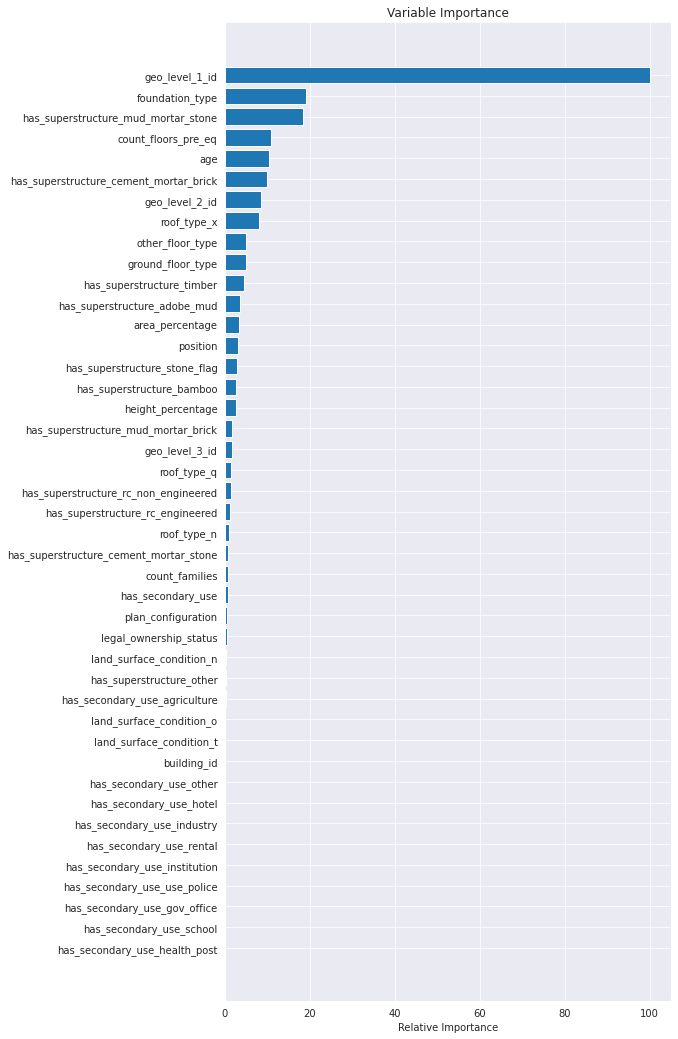

In [ ]:
# plot feature importance
feature_importance = GBI.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# plot
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
# select top 26 features (arbitrary choice from looking at the graph above)
#list(df)
top_features = ['geo_level_1_id', 'foundation_type', 'has_superstructure_mud_mortar_stone', 'roof_type_x',
                'has_superstructure_cement_mortar_brick', 'age', 'count_floors_pre_eq', 'ground_floor_type',
                'geo_level_2_id', 'other_floor_type', 'has_superstructure_adobe_mud', 'has_superstructure_rc_engineered',
                'has_superstructure_timber', 'has_superstructure_mud_mortar_brick', 'area_percentage',
                'has_superstructure_stone_flag', 'position', 'height_percentage', 'has_superstructure_bamboo',
                'has_superstructure_rc_non_engineered', 'geo_level_3_id', 'has_secondary_use', 'roof_type_q',
                'roof_type_n', 'count_families', 'has_superstructure_cement_mortar_stone']

In [ ]:
# split data to training and testing datasets, but this time only using the top features
X_fs = new_train_values[top_features]
y_fs = new_train_values['damage_grade']

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_fs, y_fs, test_size=0.30, random_state=43)

print('X_train_fs :', X_train_fs.shape)
print('X_test_fs :', X_test_fs.shape)
print('y_train_fs :', y_train_fs.shape)
print('y_test_fs :', y_test_fs.shape)

X_train_fs : (182420, 26)
X_test_fs : (78181, 26)
y_train_fs : (182420,)
y_test_fs : (78181,)


In [ ]:
# fit model using the new datasets
GBI.fit(X_train_fs, y_train_fs)

      Iter       Train Loss   Remaining Time 
         1      166227.8859            3.69m
         2      165890.3210            3.59m
         3      165541.7095            3.59m
         4      165230.0663            3.57m
         5      164934.8853            3.53m
         6      164644.3313            3.55m
         7      164357.9005            3.51m
         8      164030.6153            3.48m
         9      163738.3523            3.52m
        10      163491.1062            3.51m
        20      160825.1522            3.40m
        30      158623.9929            3.34m
        40      156517.0949            3.25m
        50      154817.1140            3.18m
        60      153206.4145            3.12m
        70      151673.8277            3.06m
        80      150464.0335            2.98m
        90      149149.6696            2.92m
       100      148078.3875            2.84m
       200      140556.6823            2.13m
       300      136744.1747            1.42m
       40

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=4,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [ ]:
# predict using the new dataset
predictions_fs = GBI.predict(X_test_fs)

In [ ]:
# print results 
prediction_result(confusion_matrix(y_test_fs, predictions_fs))

Accuracy: __ 0.872
Sensitivity: 0.646
Specificity: 0.892
F1-Score: __ 0.449
Confusion matrix:
 [[ 2571  4889    43]
 [ 1410 40355  2738]
 [   84 17309  8782]]


<a name="SMOTE"></a>
## Perform SMOTE

As mentioned [earlier](#imbalance), the data suffers from imbalance. This will be dealt with using SMOTE.

In [ ]:
# print number of instances in each class and its percentage of total 
classes = df['damage_grade'].value_counts()
tot = len(df['damage_grade'])

for cl in classes:
  print(cl, '->', round(cl/tot*100, 2), '%')

148259 -> 42.67 %
87218 -> 25.1 %
25124 -> 7.23 %


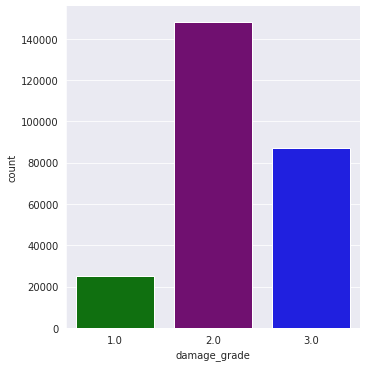

In [ ]:
# plot this info
sns.catplot(x='damage_grade', data=df, kind='count', palette=sns.color_palette(['green','purple', 'blue']))

In [ ]:
# use same dataset used for feature selection, but split it again because.. fun
X_fs_sm = X_fs
y_fs_sm = y_fs

X_train_fs_sm, X_test_fs_sm, y_train_fs_sm, y_test_fs_sm = train_test_split(X_fs_sm, y_fs_sm, test_size=0.30, random_state=43)

print('X_train :', X_train_fs_sm.shape)
print('X_test :', X_test_fs_sm.shape)
print('y_train :', y_train_fs_sm.shape)
print('y_test :', y_test_fs_sm.shape)

X_train : (182420, 26)
X_test : (78181, 26)
y_train : (182420,)
y_test : (78181,)


In [ ]:
# create SMOTE object
sm = SMOTE()

In [ ]:
# fit sample using the new data
X_smoted, y_smoted = sm.fit_sample(X_train_fs_sm, y_train_fs_sm)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


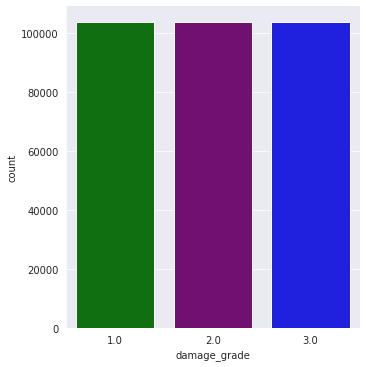

In [ ]:
# plot class counts after having performed SMOTE
temp_df = pd.DataFrame(X_smoted)
temp_df['damage_grade'] = y_smoted
sns.catplot(x='damage_grade', data=temp_df, kind='count', palette=sns.color_palette(['green','purple', 'blue']))

SMOTE has synthesized new instances of classes 1 and 3 to match the number of instances of class 2.

In [ ]:
# fit
GBI.fit(X_smoted, y_smoted)

      Iter       Train Loss   Remaining Time 
         1      340561.0863           11.10m
         2      339316.6023           10.45m
         3      337888.4734           10.41m
         4      336468.1635           10.57m
         5      335248.4508           10.60m
         6      333819.4777           10.62m
         7      332609.7212           10.57m
         8      331265.7062           10.66m
         9      329995.4791           10.67m
        10      328786.5757           10.66m
        20      317436.9644           10.33m
        30      307462.3948           10.01m
        40      299391.3270            9.76m
        50      291920.6512            9.55m
        60      285405.2133            9.32m
        70      279566.6668            9.14m
        80      274075.9106            8.95m
        90      269385.8343            8.76m
       100      265045.7509            8.56m
       200      236614.1886            6.36m
       300      221717.9381            4.22m
       40

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=4,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [70]:
# predict
predictions_fs_sm = GBI.predict(X_test_fs_sm)

In [71]:
# print results
prediction_result(confusion_matrix(y_test_fs_sm, predictions_fs_sm))

Accuracy: __ 0.820
Sensitivity: 0.483
Specificity: 0.918
F1-Score: __ 0.547
Confusion matrix:
 [[ 4456  2614   433]
 [ 4765 29207 10531]
 [  511 10440 15224]]


<a name="submit"></a>
Predict unseen data and upload csv files of respective methodology.  
  
Personal best score: 0.6778  
Achieved using: Gradient Boosting Classifier | NO Feature Selection & NO SMOTE


In [ ]:
# Gradient Boosting Classifier | NO Feature Selection & NO SMOTE
predictions = GBI.predict(new_test_values)

result = pd.DataFrame({'building_id': new_test_values.building_id, 'damage_grade': predictions.astype(int)})
result.to_csv('GBI_earthquake_damage_attempt_1.csv', index=False)

In [ ]:
# Gradient Boosting Classifier | YES Feature Selection & NO SMOTE
predictions_fs = GBI.predict(new_test_values[top_features])

result = pd.DataFrame({'building_id': new_test_values.building_id, 'damage_grade': predictions_fs.astype(int)})
result.to_csv('GBI_fs_earthquake_damage_attempt_1.csv', index=False)

In [ ]:
# Gradient Boosting Classifier | YES Feature Selection & YES SMOTE
predictions_fs_sm = GBI.predict(new_test_values[top_features])

result = pd.DataFrame({'building_id': new_test_values.building_id, 'damage_grade': predictions_fs_sm.astype(int)})
result.to_csv('GBI_fs_sm_earthquake_damage_attempt_1.csv', index=False)